In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, glossQ, dlossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.g_lossQ, model.d_lossQ,
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs, 
                                                                       model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:0.7026 dloss:1.4154 glossQ:1.0024 dlossQ:0.8398 exploreP:0.9985
Episode:1 meanR:18.0000 R:21.0000 rate:0.0420 gloss:0.7005 dloss:1.4110 glossQ:1.0026 dlossQ:0.8468 exploreP:0.9964
Episode:2 meanR:17.0000 R:15.0000 rate:0.0300 gloss:0.6845 dloss:1.4089 glossQ:1.0032 dlossQ:0.8170 exploreP:0.9950
Episode:3 meanR:16.2500 R:14.0000 rate:0.0280 gloss:0.6917 dloss:1.4046 glossQ:1.0029 dlossQ:0.8848 exploreP:0.9936
Episode:4 meanR:20.2000 R:36.0000 rate:0.0720 gloss:0.6745 dloss:1.4011 glossQ:1.0038 dlossQ:0.8656 exploreP:0.9901
Episode:5 meanR:19.6667 R:17.0000 rate:0.0340 gloss:0.6533 dloss:1.3963 glossQ:1.0037 dlossQ:0.8563 exploreP:0.9884
Episode:6 meanR:23.0000 R:43.0000 rate:0.0860 gloss:0.6475 dloss:1.3923 glossQ:1.0045 dlossQ:0.9061 exploreP:0.9842
Episode:7 meanR:24.6250 R:36.0000 rate:0.0720 gloss:0.6232 dloss:1.3877 glossQ:1.0050 dlossQ:0.9032 exploreP:0.9807
Episode:8 meanR:23.7778 R:17.0000 rate:0.0340 gloss:0.6112 dloss:1.3842 

Episode:71 meanR:28.0833 R:18.0000 rate:0.0360 gloss:0.4382 dloss:1.3410 glossQ:1.0209 dlossQ:1.1775 exploreP:0.8188
Episode:72 meanR:27.9726 R:20.0000 rate:0.0400 gloss:0.4553 dloss:1.3452 glossQ:1.0192 dlossQ:1.2011 exploreP:0.8171
Episode:73 meanR:27.9730 R:28.0000 rate:0.0560 gloss:0.4409 dloss:1.3436 glossQ:1.0199 dlossQ:1.1808 exploreP:0.8149
Episode:74 meanR:28.1867 R:44.0000 rate:0.0880 gloss:0.4561 dloss:1.3424 glossQ:1.0198 dlossQ:1.2145 exploreP:0.8114
Episode:75 meanR:28.1316 R:24.0000 rate:0.0480 gloss:0.4566 dloss:1.3398 glossQ:1.0195 dlossQ:1.2224 exploreP:0.8094
Episode:76 meanR:28.0130 R:19.0000 rate:0.0380 gloss:0.4584 dloss:1.3459 glossQ:1.0201 dlossQ:1.2143 exploreP:0.8079
Episode:77 meanR:27.8590 R:16.0000 rate:0.0320 gloss:0.4467 dloss:1.3429 glossQ:1.0208 dlossQ:1.1988 exploreP:0.8066
Episode:78 meanR:27.7848 R:22.0000 rate:0.0440 gloss:0.4521 dloss:1.3442 glossQ:1.0203 dlossQ:1.2061 exploreP:0.8049
Episode:79 meanR:27.7625 R:26.0000 rate:0.0520 gloss:0.4487 dlos

Episode:141 meanR:47.5000 R:92.0000 rate:0.1840 gloss:0.5055 dloss:1.3509 glossQ:1.0196 dlossQ:1.2989 exploreP:0.5638
Episode:142 meanR:47.7400 R:45.0000 rate:0.0900 gloss:0.5067 dloss:1.3494 glossQ:1.0145 dlossQ:1.2926 exploreP:0.5613
Episode:143 meanR:48.5700 R:104.0000 rate:0.2080 gloss:0.4991 dloss:1.3484 glossQ:1.0151 dlossQ:1.2862 exploreP:0.5556
Episode:144 meanR:48.2300 R:24.0000 rate:0.0480 gloss:0.4988 dloss:1.3498 glossQ:1.0159 dlossQ:1.2907 exploreP:0.5543
Episode:145 meanR:48.9000 R:82.0000 rate:0.1640 gloss:0.5002 dloss:1.3521 glossQ:1.0147 dlossQ:1.2907 exploreP:0.5499
Episode:146 meanR:49.6300 R:109.0000 rate:0.2180 gloss:0.5006 dloss:1.3533 glossQ:1.0151 dlossQ:1.2716 exploreP:0.5440
Episode:147 meanR:49.8500 R:58.0000 rate:0.1160 gloss:0.5091 dloss:1.3517 glossQ:1.0160 dlossQ:1.2820 exploreP:0.5409
Episode:148 meanR:49.8400 R:33.0000 rate:0.0660 gloss:0.5086 dloss:1.3495 glossQ:1.0144 dlossQ:1.2874 exploreP:0.5392
Episode:149 meanR:51.2200 R:161.0000 rate:0.3220 gloss

Episode:211 meanR:97.5900 R:146.0000 rate:0.2920 gloss:0.5959 dloss:1.3693 glossQ:1.0067 dlossQ:1.3674 exploreP:0.2627
Episode:212 meanR:97.5900 R:85.0000 rate:0.1700 gloss:0.6003 dloss:1.3658 glossQ:1.0053 dlossQ:1.3635 exploreP:0.2605
Episode:213 meanR:98.2700 R:147.0000 rate:0.2940 gloss:0.6012 dloss:1.3671 glossQ:1.0085 dlossQ:1.3864 exploreP:0.2569
Episode:214 meanR:99.2200 R:111.0000 rate:0.2220 gloss:0.6025 dloss:1.3665 glossQ:1.0079 dlossQ:1.3868 exploreP:0.2542
Episode:215 meanR:100.0700 R:113.0000 rate:0.2260 gloss:0.5937 dloss:1.3663 glossQ:1.0080 dlossQ:1.3726 exploreP:0.2514
Episode:216 meanR:101.4600 R:189.0000 rate:0.3780 gloss:0.5931 dloss:1.3654 glossQ:1.0080 dlossQ:1.3731 exploreP:0.2469
Episode:217 meanR:101.3400 R:105.0000 rate:0.2100 gloss:0.6054 dloss:1.3698 glossQ:1.0087 dlossQ:1.3814 exploreP:0.2444
Episode:218 meanR:101.8600 R:152.0000 rate:0.3040 gloss:0.5959 dloss:1.3661 glossQ:1.0116 dlossQ:1.3623 exploreP:0.2409
Episode:219 meanR:103.0000 R:178.0000 rate:0.

Episode:280 meanR:157.3000 R:324.0000 rate:0.6480 gloss:0.6582 dloss:1.3765 glossQ:1.0142 dlossQ:1.3835 exploreP:0.0870
Episode:281 meanR:157.7700 R:173.0000 rate:0.3460 gloss:0.6708 dloss:1.3772 glossQ:1.0205 dlossQ:1.3988 exploreP:0.0857
Episode:282 meanR:158.0000 R:318.0000 rate:0.6360 gloss:0.6722 dloss:1.3787 glossQ:1.0182 dlossQ:1.3911 exploreP:0.0833
Episode:283 meanR:158.4700 R:167.0000 rate:0.3340 gloss:0.6672 dloss:1.3784 glossQ:1.0153 dlossQ:1.3832 exploreP:0.0821
Episode:284 meanR:158.9300 R:169.0000 rate:0.3380 gloss:0.6749 dloss:1.3779 glossQ:1.0149 dlossQ:1.4171 exploreP:0.0809
Episode:285 meanR:161.0900 R:231.0000 rate:0.4620 gloss:0.6746 dloss:1.3758 glossQ:1.0157 dlossQ:1.4132 exploreP:0.0792
Episode:286 meanR:162.5300 R:231.0000 rate:0.4620 gloss:0.6697 dloss:1.3786 glossQ:1.0177 dlossQ:1.3798 exploreP:0.0777
Episode:287 meanR:164.8300 R:315.0000 rate:0.6300 gloss:0.6709 dloss:1.3776 glossQ:1.0151 dlossQ:1.3883 exploreP:0.0756
Episode:288 meanR:166.3000 R:241.0000 ra

Episode:349 meanR:206.1700 R:500.0000 rate:1.0000 gloss:0.8048 dloss:1.3742 glossQ:1.0411 dlossQ:1.5117 exploreP:0.0273
Episode:350 meanR:207.6000 R:320.0000 rate:0.6400 gloss:0.8354 dloss:1.3713 glossQ:1.0477 dlossQ:1.5771 exploreP:0.0267
Episode:351 meanR:208.7000 R:248.0000 rate:0.4960 gloss:0.8221 dloss:1.3739 glossQ:1.0450 dlossQ:1.5425 exploreP:0.0263
Episode:352 meanR:208.9800 R:155.0000 rate:0.3100 gloss:0.8243 dloss:1.3787 glossQ:1.0458 dlossQ:1.5620 exploreP:0.0261
Episode:353 meanR:208.2400 R:148.0000 rate:0.2960 gloss:0.8081 dloss:1.3715 glossQ:1.0381 dlossQ:1.5068 exploreP:0.0258
Episode:354 meanR:208.1800 R:232.0000 rate:0.4640 gloss:0.8283 dloss:1.3689 glossQ:1.0385 dlossQ:1.5274 exploreP:0.0255
Episode:355 meanR:211.7000 R:500.0000 rate:1.0000 gloss:0.8243 dloss:1.3707 glossQ:1.0429 dlossQ:1.5271 exploreP:0.0247
Episode:356 meanR:213.1100 R:301.0000 rate:0.6020 gloss:0.8271 dloss:1.3657 glossQ:1.0470 dlossQ:1.5436 exploreP:0.0243
Episode:357 meanR:215.2300 R:346.0000 ra

Episode:418 meanR:337.5600 R:500.0000 rate:1.0000 gloss:1.0860 dloss:1.2234 glossQ:1.0874 dlossQ:1.7814 exploreP:0.0113
Episode:419 meanR:340.6000 R:500.0000 rate:1.0000 gloss:1.0906 dloss:1.2325 glossQ:1.0955 dlossQ:1.8615 exploreP:0.0112
Episode:420 meanR:340.2000 R:123.0000 rate:0.2460 gloss:1.0838 dloss:1.2064 glossQ:1.0870 dlossQ:1.7848 exploreP:0.0112
Episode:421 meanR:342.5400 R:486.0000 rate:0.9720 gloss:1.0951 dloss:1.1930 glossQ:1.1363 dlossQ:1.8693 exploreP:0.0112
Episode:422 meanR:345.8400 R:500.0000 rate:1.0000 gloss:1.1054 dloss:1.1869 glossQ:1.1050 dlossQ:1.8618 exploreP:0.0111
Episode:423 meanR:347.5400 R:500.0000 rate:1.0000 gloss:1.1470 dloss:1.2028 glossQ:1.1218 dlossQ:1.9739 exploreP:0.0110
Episode:424 meanR:349.7200 R:500.0000 rate:1.0000 gloss:1.1113 dloss:1.1808 glossQ:1.1134 dlossQ:1.9183 exploreP:0.0110
Episode:425 meanR:351.3700 R:404.0000 rate:0.8080 gloss:1.1463 dloss:1.1719 glossQ:1.1357 dlossQ:2.0053 exploreP:0.0110
Episode:426 meanR:354.0100 R:500.0000 ra

Episode:487 meanR:404.7300 R:500.0000 rate:1.0000 gloss:1.3478 dloss:0.8185 glossQ:1.5182 dlossQ:3.0226 exploreP:0.0101
Episode:488 meanR:404.7300 R:500.0000 rate:1.0000 gloss:1.3402 dloss:0.8021 glossQ:1.6775 dlossQ:3.5139 exploreP:0.0101
Episode:489 meanR:401.9900 R:226.0000 rate:0.4520 gloss:1.3835 dloss:0.7865 glossQ:1.6294 dlossQ:3.3266 exploreP:0.0101
Episode:490 meanR:401.9900 R:500.0000 rate:1.0000 gloss:1.3895 dloss:0.8341 glossQ:1.7291 dlossQ:3.7422 exploreP:0.0101
Episode:491 meanR:405.0800 R:500.0000 rate:1.0000 gloss:1.3420 dloss:0.7956 glossQ:1.7395 dlossQ:3.4089 exploreP:0.0101
Episode:492 meanR:405.5100 R:500.0000 rate:1.0000 gloss:1.3577 dloss:0.7671 glossQ:1.6331 dlossQ:3.3592 exploreP:0.0101
Episode:493 meanR:407.8200 R:500.0000 rate:1.0000 gloss:1.3860 dloss:0.7551 glossQ:1.6863 dlossQ:3.5458 exploreP:0.0101
Episode:494 meanR:405.8200 R:300.0000 rate:0.6000 gloss:1.4287 dloss:0.7810 glossQ:1.7426 dlossQ:3.8650 exploreP:0.0101
Episode:495 meanR:406.3500 R:500.0000 ra

Episode:556 meanR:398.4700 R:500.0000 rate:1.0000 gloss:1.5344 dloss:0.3914 glossQ:6.8204 dlossQ:9.0291 exploreP:0.0100
Episode:557 meanR:395.5600 R:209.0000 rate:0.4180 gloss:1.5201 dloss:0.3028 glossQ:6.6873 dlossQ:8.0257 exploreP:0.0100
Episode:558 meanR:392.3900 R:183.0000 rate:0.3660 gloss:1.5168 dloss:0.3193 glossQ:7.0430 dlossQ:9.3150 exploreP:0.0100
Episode:559 meanR:392.3900 R:500.0000 rate:1.0000 gloss:1.5342 dloss:0.3273 glossQ:7.1728 dlossQ:9.0971 exploreP:0.0100
Episode:560 meanR:395.6700 R:500.0000 rate:1.0000 gloss:1.5256 dloss:0.3202 glossQ:7.2976 dlossQ:8.6268 exploreP:0.0100
Episode:561 meanR:397.5600 R:500.0000 rate:1.0000 gloss:1.5501 dloss:0.3177 glossQ:7.8537 dlossQ:10.1191 exploreP:0.0100
Episode:562 meanR:397.5800 R:172.0000 rate:0.3440 gloss:1.5697 dloss:0.3524 glossQ:8.3521 dlossQ:11.2800 exploreP:0.0100
Episode:563 meanR:400.9800 R:500.0000 rate:1.0000 gloss:1.5404 dloss:0.3006 glossQ:7.9976 dlossQ:9.3345 exploreP:0.0100
Episode:564 meanR:400.3600 R:127.0000 

Episode:624 meanR:422.1900 R:325.0000 rate:0.6500 gloss:1.7019 dloss:0.0708 glossQ:15.6473 dlossQ:12.8053 exploreP:0.0100
Episode:625 meanR:422.1900 R:500.0000 rate:1.0000 gloss:1.7095 dloss:0.0730 glossQ:15.8622 dlossQ:14.0397 exploreP:0.0100
Episode:626 meanR:422.1900 R:500.0000 rate:1.0000 gloss:1.7222 dloss:0.0765 glossQ:17.1220 dlossQ:13.7166 exploreP:0.0100
Episode:627 meanR:422.1900 R:500.0000 rate:1.0000 gloss:1.7016 dloss:0.0864 glossQ:17.7577 dlossQ:14.4818 exploreP:0.0100
Episode:628 meanR:424.9900 R:500.0000 rate:1.0000 gloss:1.7031 dloss:0.0727 glossQ:18.2284 dlossQ:14.6711 exploreP:0.0100
Episode:629 meanR:422.4000 R:241.0000 rate:0.4820 gloss:1.6555 dloss:0.0919 glossQ:18.2332 dlossQ:14.8565 exploreP:0.0100
Episode:630 meanR:425.9800 R:500.0000 rate:1.0000 gloss:1.7016 dloss:0.0773 glossQ:18.9996 dlossQ:15.9875 exploreP:0.0100
Episode:631 meanR:425.9800 R:500.0000 rate:1.0000 gloss:1.6811 dloss:0.0883 glossQ:19.8738 dlossQ:15.8313 exploreP:0.0100
Episode:632 meanR:424.15

Episode:691 meanR:450.5900 R:500.0000 rate:1.0000 gloss:1.7156 dloss:0.0637 glossQ:186.0959 dlossQ:103.2990 exploreP:0.0100
Episode:692 meanR:450.5900 R:500.0000 rate:1.0000 gloss:1.7240 dloss:0.0632 glossQ:190.4989 dlossQ:106.2574 exploreP:0.0100
Episode:693 meanR:450.5900 R:500.0000 rate:1.0000 gloss:1.7237 dloss:0.0548 glossQ:197.4707 dlossQ:109.6822 exploreP:0.0100
Episode:694 meanR:448.7900 R:320.0000 rate:0.6400 gloss:1.7322 dloss:0.0676 glossQ:196.6063 dlossQ:108.9703 exploreP:0.0100
Episode:695 meanR:448.7900 R:500.0000 rate:1.0000 gloss:1.7016 dloss:0.0622 glossQ:199.7969 dlossQ:110.7434 exploreP:0.0100
Episode:696 meanR:445.2900 R:150.0000 rate:0.3000 gloss:1.7738 dloss:0.0455 glossQ:204.5674 dlossQ:114.2200 exploreP:0.0100
Episode:697 meanR:447.4400 R:500.0000 rate:1.0000 gloss:1.7391 dloss:0.0545 glossQ:206.1919 dlossQ:115.0074 exploreP:0.0100
Episode:698 meanR:447.4400 R:500.0000 rate:1.0000 gloss:1.7977 dloss:0.0611 glossQ:208.5428 dlossQ:116.2747 exploreP:0.0100
Episode:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

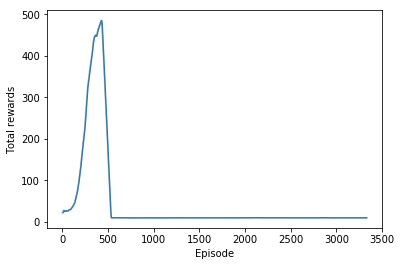

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

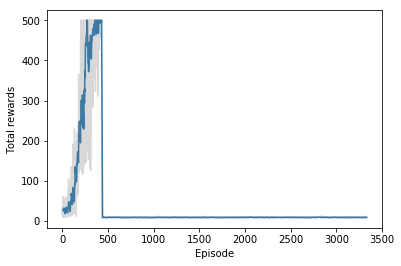

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

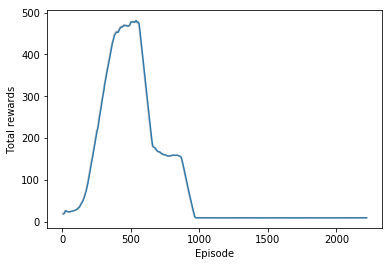

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

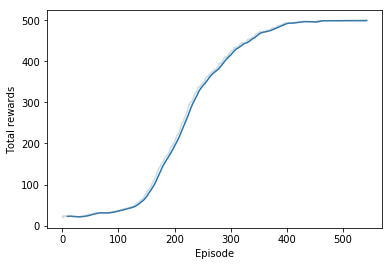

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

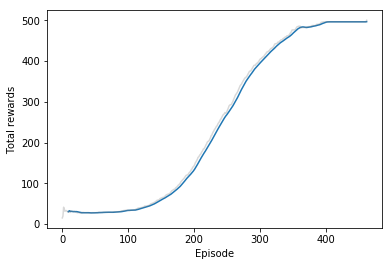

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

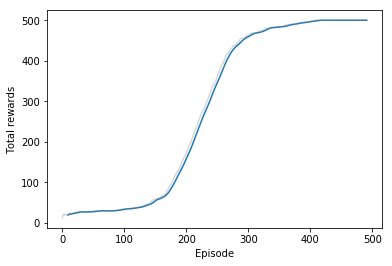

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

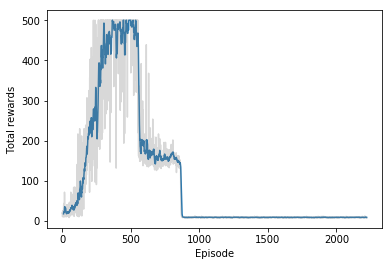

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

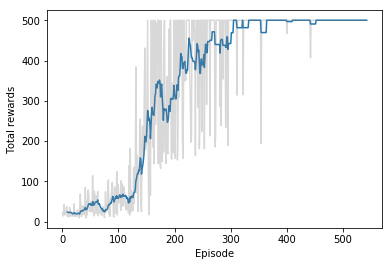

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

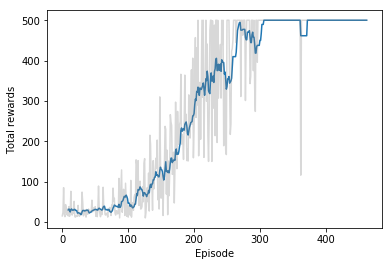

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

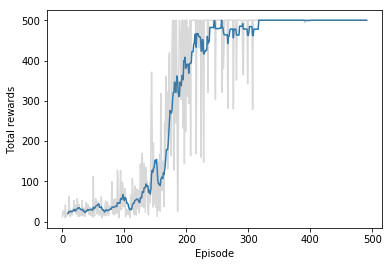

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.